In [5]:
import sys
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/models/')
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/')

import comp_models
from utils import  soft_max, compute_aic, compute_bic

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table
import pandas as pd

dat = pd.read_csv('../../Data/bx_data.csv', index_col=0)
game = dat.loc[dat.turker_id == 10].reset_index(drop=True)

In [3]:

WORLD_SIZE = 6#int( np.ceil( game.shape[0]/3 ))
stepP = (.11 - (-.1))/WORLD_SIZE
phi = np.arange(-0.1,.11, stepP).astype(float)
phi.tolist().reverse()
stepT = .51/WORLD_SIZE
theta = np.arange(0, .51, stepT).astype(float)
phi[np.floor(len(phi)/2).astype(int)]=0  #make sure the center is 0

startState = [np.random.randint(0,WORLD_SIZE),np.random.randint(0,WORLD_SIZE)]

discount = 0.39

world = np.zeros((WORLD_SIZE, WORLD_SIZE))
newWorld = np.zeros((WORLD_SIZE, WORLD_SIZE))
# left, up, right, down
actions = ['W', 'N', 'E', 'S', 'NE', 'NW', 'SE', 'SW','STAY']


def MPM2(investment, multiplier, theta, phi):  # for param space simulations
    x = np.unique(np.round(np.append(np.arange(0, int(multiplier) * int(investment), int(multiplier) * int(investment) / 10),int(multiplier * investment)))).astype(int)
    pi = ((investment * multiplier) - x) / (investment * multiplier)  # Money kept by Trustee (as fraction of inv*mult)
    expectation = investment * 2
    guilt = ((expectation - x) / (investment * 4)) ** 2  # Guilt term
    ie = (((investment * multiplier) - x) / ((investment * multiplier) + (10 - investment)) - .5) ** 2  # Inequity aversion term
    u = theta * pi - (1 - theta) * (np.minimum(guilt + phi, ie - phi))  # Utility function
    max_util = x[np.where(u == max(u))]
    if len(max_util) > 1:
        max_util = max_util[[0]]
    if max_util.size == 0:
        max_util = np.array([0])
    # UNCOMMENT BELOW IF WORKING WITH SIMULATED DATA
    # max_util = int(max_util) + np.random.normal(0.0, scale = noise)
    return max_util


def observeReward(t, i, j):
    prediction = MPM2(investment=game.inv.iloc[t].astype('int'), multiplier=game.mult.iloc[t].astype('int'), theta= theta[j], phi=phi[i] )
    pred = (prediction/game['im'][t]) * 100
    observation = (game['ret'][t]/game['im'][t]) * 100
    reward = ((100 - abs(pred - observation)) * .01) * 2 #times 2 may not be needed
    return float(reward)


def createRewardFunction(t):  #i is rows and j is columns
    nextState = []
    actionReward = []
    for i in range(0, WORLD_SIZE):
        nextState.append([])
        actionReward.append([])
        for j in range(0, WORLD_SIZE):
            next = dict()
            reward = dict()

            next['STAY'] = [i,j]
            reward['STAY'] = observeReward(t, i, j)

            if i == 0:
                next['N'] = [i, j]
                reward['N'] = observeReward(t, i, j)
            else:
                next['N'] = [i - 1, j]
                reward['N'] = observeReward(t, i-1, j)

            if i == 0 and j == 0:
                next['NW'] = [i,j]
                reward['NW'] = observeReward(t, i, j)
            elif i == 0:
                next['NW'] = [i, j-1]
                reward['NW'] = observeReward(t, i, j-1)
            elif j == 0:
                next['NW'] = [i-1, j]
                reward['NW'] = observeReward(t, i-1, j)
            else:
                next['NW'] = [i-1, j-1]
                reward['NW'] = observeReward(t, i-1, j-1)

            if i == 0 and j == WORLD_SIZE - 1:
                next['NE'] = [i, j]
                reward['NE'] = observeReward(t, i, j)
            elif i ==0:
                next['NE'] = [i, j+1]
                reward['NE'] = observeReward(t, i, j+1)
            elif j == WORLD_SIZE-1:
                next['NE'] = [i-1, j]
                reward['NE'] = observeReward(t, i-1, j)
            else:
                next['NE'] = [i-1, j+1]
                reward['NE'] = observeReward(t, i-1, j+1)

            if i == WORLD_SIZE - 1 and j == 0:
                next['SW'] = [i,j]
                reward['SW'] = observeReward(t, i, j)
            elif i == WORLD_SIZE - 1:
                next['SW'] = [i, j-1]
                reward['SW'] = observeReward(t, i, j-1)
            elif j == 0:
                next['SW'] = [i+1, j]
                reward['SW'] = observeReward(t, i+1, j)
            else:
                next['SW'] = [i+1, j-1]
                reward['SW'] = observeReward(t, i+1, j-1)

            if i == WORLD_SIZE - 1 and j == WORLD_SIZE - 1:
                next['SE'] = [i, j]
                reward['SE'] = observeReward(t, i, j)
            elif i == WORLD_SIZE - 1:
                next['SE'] = [i, j+1]
                reward['SE'] = observeReward(t, i, j+1)
            elif j == WORLD_SIZE-1:
                next['SE'] = [i+1, j]
                reward['SE'] = observeReward(t, i+1, j)
            else:
                next['SE'] = [i+1, j+1]
                reward['SE'] = observeReward(t, i+1, j+1)


            if i == WORLD_SIZE - 1:
                next['S'] = [i, j]
                reward['S'] = observeReward(t, i, j)
            else:
                next['S'] = [i + 1, j]
                reward['S'] = observeReward(t, i+1, j)

            if j == 0:
                next['W'] = [i, j]
                reward['W'] = observeReward(t, i, j)
            else:
                next['W'] = [i, j - 1]
                reward['W'] = observeReward(t, i, j-1)

            if j == WORLD_SIZE - 1:
                next['E'] = [i, j]
                reward['E'] = observeReward(t,i,j)
            else:
                next['E'] = [i, j + 1]
                reward['E'] = observeReward(t, i, j+1)


            nextState[i].append(next)
            actionReward[i].append(reward)
    return nextState, actionReward


def optimalPolicy(world):
    while True:
        # keep iteration until convergence
        newWorld = np.zeros((WORLD_SIZE, WORLD_SIZE))
        for i in range(0, WORLD_SIZE):
            for j in range(0, WORLD_SIZE):
                values = []
                for action in actions:
                    newPosition = nextState[i][j][action]
                    # value iteration
                    values.append(actionReward[i][j][action] + discount * world[newPosition[0], newPosition[1]])
                newWorld[i][j] = np.max(values)
        if np.sum(np.abs(world - newWorld)) < 1e-4:
            print('Optimal Policy')
            #draw_image(np.round(newWorld, decimals=2))
            break
        world = newWorld

    return world



# starting with a random (uncontrolled) policy such that P(action|state) is uniform )
actionProb = []
for i in range(0, WORLD_SIZE):
    actionProb.append([])
    for j in range(0, WORLD_SIZE):
        actionProb[i].append(dict({'W': 1/len(actions), 'N': 1/len(actions), 'E': 1/len(actions), 'S': 1/len(actions),
                                   'SE': 1/len(actions), 'SW': 1/len(actions), 'NE': 1/len(actions), 'NW':1/len(actions),
                                   'STAY': 1/len(actions)}))


chosenAct = []
currstate = startState

optimizing policy for trial 0
Optimal Policy
agent moved W
optimizing policy for trial 1
Optimal Policy
agent moved W
optimizing policy for trial 2
Optimal Policy
agent moved W
optimizing policy for trial 3
Optimal Policy
agent moved W
optimizing policy for trial 4
Optimal Policy
agent moved W
optimizing policy for trial 5
Optimal Policy
agent moved W
optimizing policy for trial 6
Optimal Policy
agent moved W
optimizing policy for trial 7
Optimal Policy
agent moved W
optimizing policy for trial 8
Optimal Policy
agent moved W
optimizing policy for trial 9
Optimal Policy
agent moved W
optimizing policy for trial 10
Optimal Policy
agent moved W
optimizing policy for trial 11
Optimal Policy
agent moved W
optimizing policy for trial 12
Optimal Policy
agent moved W
optimizing policy for trial 13
Optimal Policy
agent moved W
optimizing policy for trial 14
Optimal Policy
agent moved W
optimizing policy for trial 15
Optimal Policy
agent moved W
optimizing policy for trial 16
Optimal Policy
agen

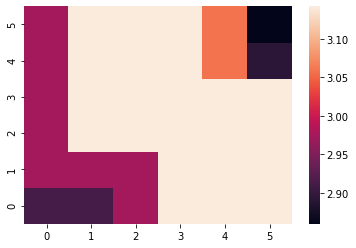

In [4]:
for t in np.arange(game.shape[0]):
    print('optimizing policy for trial', t)
    nextState, actionReward = createRewardFunction(t)
    world = optimalPolicy(world)
    # find the next move
    # look up and choose the action with the highest value

    chosenAct.append(max(actionReward[currstate[0]][currstate[1]]))
    currstate = nextState[currstate[0]][currstate[1]][chosenAct[t]]
    print('agent moved '+chosenAct[t])


import seaborn as sns
g = sns.heatmap(world)
g.invert_yaxis()
plt.show()

In [10]:
n_states = 6
alpha = discount
#def mentalState_space(game, alpha, tau, n_states):
decimals = int(np.log10(n_states) + 1)
#phi = np.around(np.arange(-0.1, 0.10001, 0.2 / n_states).astype('float'), decimals=decimals)
phi = np.linspace(-.1, .1, n_states)
theta = np.linspace(0, .5, n_states)
#theta = np.around(np.arange(0, .50001, .5 / n_states).astype('float'), decimals=decimals)
p_strat = pd.DataFrame(data=1/(n_states**2), columns=theta, index=phi)
counterfactuals = pd.DataFrame(columns=theta, index=phi)
pred_err = pd.DataFrame(columns=theta, index=phi)  # hypothetical/counterfactual prediction errors
first_guess = (theta[np.random.randint(len(theta))], phi[np.random.randint(len(phi))])  # initialize randomly
mb_pred_bx = np.zeros(len(game))  # model predicted behavior
future_state = np.nan
# string state-space into vector
tempStates = [[(thay, phii) for thay in theta] for phii in phi]
states = [x for l in tempStates for x in l] # [row1a, row1b,..row2a, row2b...]
for t in np.arange(len(game)):
    if t == 0:
        mb_pred_bx[0] = comp_models.mp_model_ppsoe(inv=game.inv.iloc[0], mult=game.mult.iloc[0],
                                       theta=first_guess[0], phi=first_guess[1])
    else:
        mb_pred_bx[t] = comp_models.mp_model_ppsoe(inv=game.inv.iloc[0], mult=game.mult.iloc[0],
                                       theta=future_state[0], phi=future_state[1])
    for theyta in theta:
        for phee in phi:
            counterfactuals[theyta][phee] = comp_models.mp_model_ppsoe(inv=game.inv.iloc[t], mult=game.mult.iloc[t], theta=theyta, phi=phee)
            pred_err[theyta][phee] = abs(game.ret.iloc[t] - counterfactuals[theyta][phee])  # counterfactual predictions errors
            # probability update
            p_strat[theyta][phee] = p_strat[theyta][phee] + alpha * ((1 - (pred_err[theyta][phee] / (game.im.iloc[t]))) - p_strat[theyta][phee])
    #vectorize probabilities
    tempProb = [[p_strat[thay][phe] for thay in theta] for phe in phi]  # [[row1][row2]....
    prob = [x for l in  tempProb for x in l ] # [row1a, row1b, row1c..row2a, row2b...]
    temp = soft_max(prob, .001)
    future_state = states[np.random.choice(np.arange(len(states)), p=temp)]
#    return mb_pred_bx

/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/utils.py:27: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(np.divide(np.array(x), tau))
/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/utils.py:28: RuntimeWarning: invalid value encountered in true_divide
  r = np.divide(e_x, e_x.sum(axis=0))


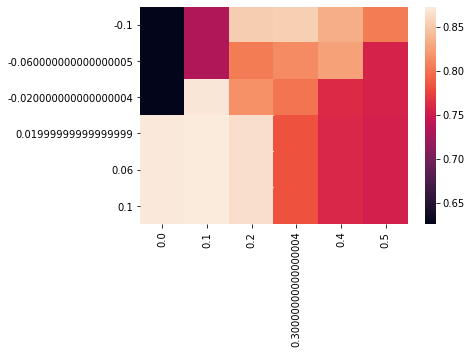

In [11]:
sns.heatmap(p_strat)